#  imports

In [2]:
import pygeostat as gs
import gglib as gg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
import rmutils as rm
from gglib.datamgmt.simpleio import *
%matplotlib inline

The imports are copied to the clipboard


In [3]:
import spatialcluster as sp

In [4]:
variables = ['Ni', 'Fe', 'SiO2', 'MgO']
nsvariables = [f'NS_{v}' for v in variables]

# functions

In [5]:
sys.path.insert(0, '../')
import validator.crossval as cv
import validator.validation_utils as vf
import validator.error_functions as ef
import validator.exporter as exp
exp.init_project('nilat_')

# parameters

In [6]:
masterseed = 201904
declus_cellsize = 50
saveplots = True
rng = np.random.RandomState(masterseed)
seeds = rng.permutation(2500)[:500]
ltrim = -999
searchparams = (50, 0, 0, 800, 600, 10)
nprocesses = 10
nreal = 100

workdir = 'L:/PhD-Wrapup/Nilat/sim/'
gs.ensure_path(workdir)

In [7]:
catvarmodels = gg.load_pickle('catvarmodels.pkl')
nsvarmodels = gg.load_pickle('nsvarmodels.pkl')

In [8]:
points = gg.PointContainer('nilat_maincats.dat')

griddef = gg.GridDef(open('griddef', 'r').read())
print(griddef)

92 1879.81 10.0 
99 8953.94 10.0 
23 896.36 2.0


In [9]:
nfolds = 10
ifolds = np.arange(nfolds, dtype=int) + 1

# read validation files

In [10]:
names = ['modelcats', 'mvclus', 
         'betteragglom', 'reals_ensbest']
titles = ["Geological Categories", 'Multivariate Clusters', 
          "Improved Spatial Clusters", "Spatial Cluster Realizations"]
names = dict([(k, t) for k, t in zip(names, titles)])

In [11]:
valdict = {}
for var in variables:
    for name, title in names.items():
        for ifold in ifolds:
            valdict[var, name, ifold] = read_gslib(f'{workdir}{name}_{var}_fold{ifold}.out')

FileNotFoundError: [Errno 2] No such file or directory: 'L:/PhD-Wrapup/Nilat/sim/modelcats_Ni_fold2.out'

In [ ]:
realvars = [f'real{ireal}' for ireal in range(nreal)]
sisvars = [f'sis{ireal}' for ireal in range(nreal)]
ucats = points['modelcats'].unique()

In [ ]:
valdict[var, name, ifold].columns

# histpltsim

In [ ]:
testcts = {}
for ifold in ifolds:
    validation_file = gg.PointContainer(f'{workdir}Validation{ifold:02}.dat')
    # DECLUS
    declus = gg.PolyDecluster(validation_file, griddef.convert_to_2d(),
                              dhcol=validation_file.dh)
    validation_file['Declustering Weight'] = declus.decluster()
    validation_file['Declustering Weight'] /= validation_file['Declustering Weight'].sum()
    pval = cv.get_pvalue(validation_file['Declustering Weight'], 96)
    validation_file.loc[validation_file['Declustering Weight'] > pval, 'Declustering Weight'] = pval
    
    testcts[ifold] = validation_file

# validation plotting

## selection by entropy

In [ ]:
def select_locations(etpy):
    return (etpy < 0.4)

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(10, 5))
var = 'Ni'
name = 'modelcats'
kidxs = {}
for ifold, ax in zip(ifolds, axs.flatten()):
    thisdata = valdict[var, name, ifold]
    etpy = ef.entropy(thisdata[sisvars], ucats)
    kidxs[ifold] = select_locations(etpy)
    gs.histplt(etpy, ax=ax, icdf=True)
# axs[-1, -1].set_axis_off()
plt.tight_layout()

## scatxval

In [85]:
shape = (2, 2)
figsize = (shape[1] * 2, shape[0] * 2)
qf = gg.QuickFormatter(fs=7, grid=False)
plt.rcParams.update({'figure.dpi': 125, 'savefig.dpi': 125})

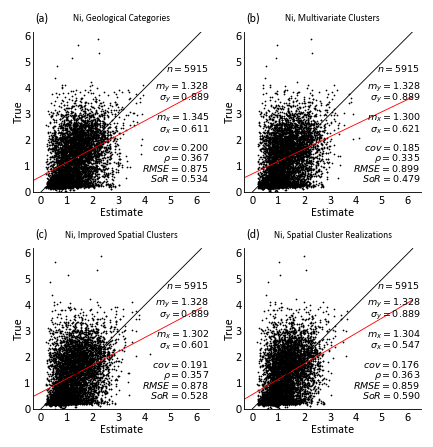

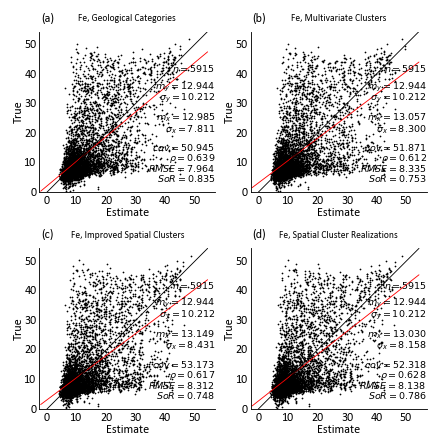

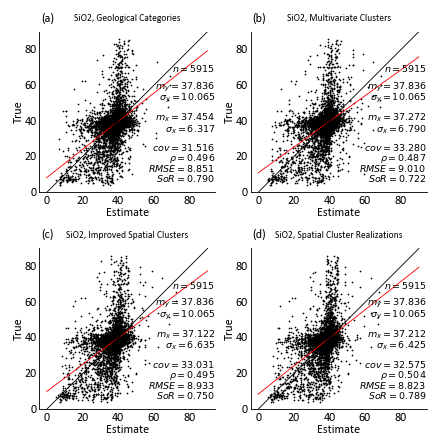

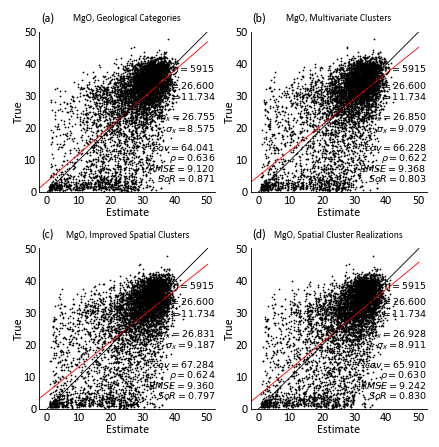

In [86]:
for var in variables:
    acaxs = qf.getax(len(names), shape=shape, figsize=figsize)
    iax = 0
    for (name, title), ax in zip(names.items(), acaxs):
        etypes = np.empty(0)
        truths = np.empty(0)
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            truth = thisdata[f'{var}_truth']
            reals = thisdata[realvars]
            etype = reals.mean(axis=1).values.flatten()
            truths = np.concatenate((truths, truth))
            etypes = np.concatenate((etypes, etype))
        ax = gs.scatxval(etypes, truths, ax=ax, 
                         title=f'{var}, {title}', ms=1, 
                         pltstyle='pt5.5')
        qf(ax, 
           fignum=iax, lblxy=(0.01, 1.05), aspect=1, nticks='auto', 
           xlim=(0, None), ylim=(0, None))
        iax += 1
    plt.subplots_adjust(hspace=0.35)
    exp.exportfigure(f'scatxval_all_{var}.pdf')

## accplts

In [87]:
statnames = {
    'avgvar': 'U', 
    'mse': 'MSE', 
    'acc': 'Accuracy', 
    'pre': 'Precision', 
    'goo': 'Goodness'
}

## pool folds

In [88]:
accpltdict = {}
for var in variables:
    iax = 0
    for name, title in names.items():
        probs = None
        ntotal = 0
        truth = np.empty(0)
        reals = np.empty((0, nreal))
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            truth = np.concatenate((truth, thisdata[f'{var}_truth']), axis=0)
            reals = np.concatenate((reals, thisdata[realvars]), axis=0)
        thisaccsim, sumstats = gs.accsim(truth, reals)
        accpltdict[var, name] = [thisaccsim['ProbInt'], thisaccsim['FracIn'], sumstats]

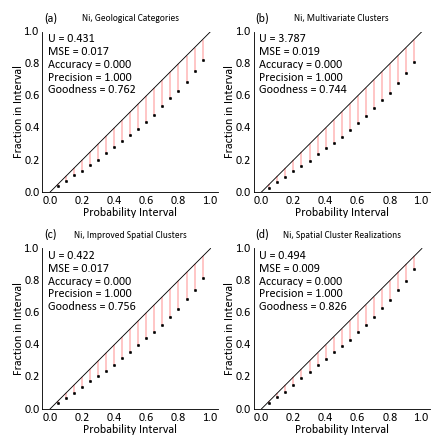

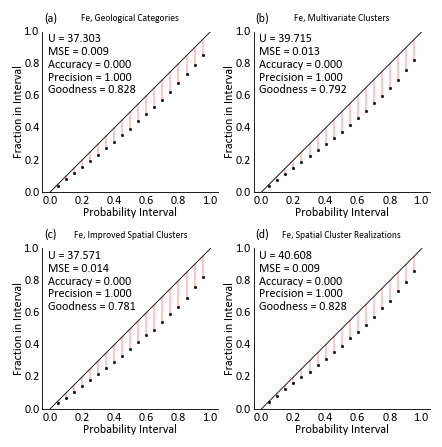

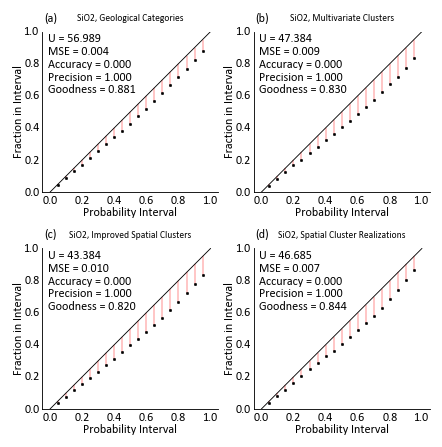

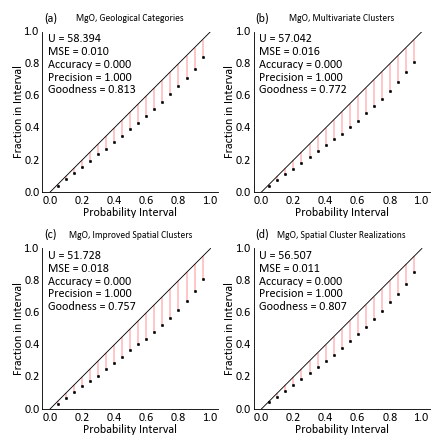

In [89]:
for var in variables:
    acaxs = qf.getax(len(names), shape=shape, figsize=figsize)
    iax = 0
    for (name, title), ax in zip(names.items(), acaxs):
        probint, fracin, sumstats = accpltdict[var, name]
        ax = gs.accplt(x=probint, y=fracin, ax=ax, stat_blk=False, 
                       title=f'{var}, {title}', pltstyle='pt5.5', ms=2)
        qf(ax, fignum=iax, lblxy=(0.01, 1.05), 
           annot='\n'.join([f'{statnames[k]} = {sumstats[k]:.3f}' 
                            for k in statnames.keys()]), 
           annha='left', annva='top', annxy=(0.03, 0.99),
           aspect=1, nticks='auto',
          )
        iax += 1
    plt.subplots_adjust(hspace=0.35)
    exp.exportfigure(f'accplt_all_{var}.pdf')

## averaged after fold

In [90]:
accpltdict = {}
for var in variables:
    iax = 0
    for name, title in names.items():
        probs = None
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            truth = thisdata[f'{var}_truth']
            reals = thisdata[realvars]
            thisaccsim, sumstats = gs.accsim(truth, reals)
            if probs is None:
                probs = thisaccsim 
            else:
                probs['FracIn'] += thisaccsim['FracIn']
        accpltdict[var, name] = [probs['ProbInt'], probs['FracIn'] / nfolds, sumstats]

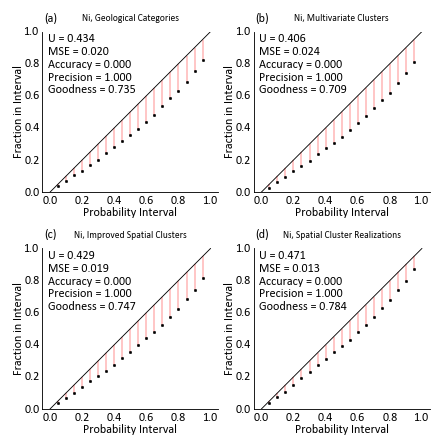

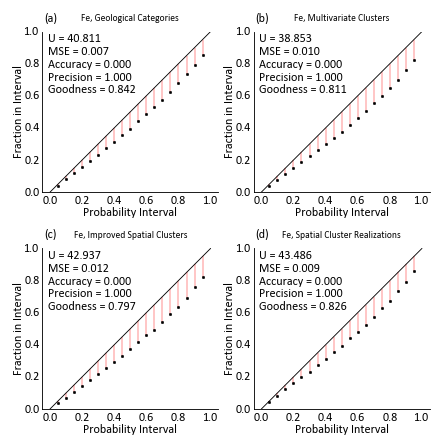

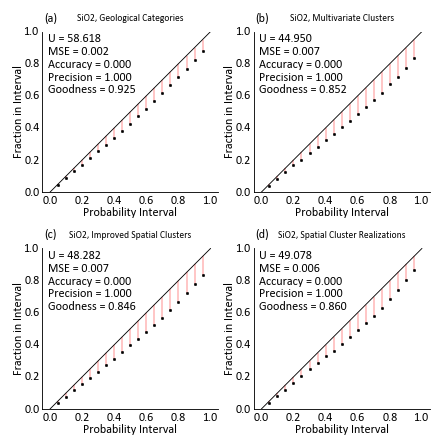

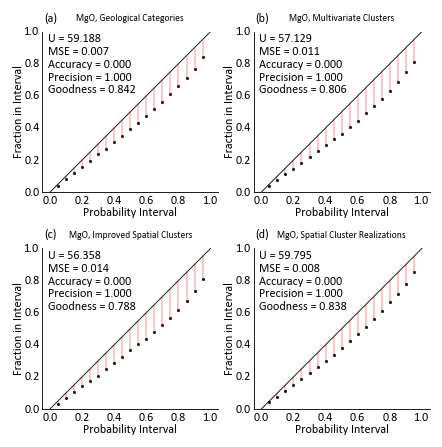

In [91]:
for var in variables:
    acaxs = qf.getax(len(names), shape=shape, figsize=figsize)
    iax = 0
    for (name, title), ax in zip(names.items(), acaxs):
        probint, fracin, sumstats = accpltdict[var, name]
        ax = gs.accplt(x=probint, y=fracin, ax=ax, stat_blk=False, 
                       title=f'{var}, {title}', pltstyle='pt5.5', ms=2)
        qf(ax, fignum=iax, lblxy=(0.01, 1.05), 
           annot='\n'.join([f'{statnames[k]} = {sumstats[k]:.3f}' 
                            for k in statnames.keys()]), 
           annha='left', annva='top', annxy=(0.03, 0.99),
           aspect=1, nticks='auto',
          )
        iax += 1
    plt.subplots_adjust(hspace=0.35)
    exp.exportfigure(f'accplt_all_{var}.pdf')

# validation tables

In [92]:
from collections import defaultdict

## with entropy

In [93]:
ucats = points['modelcats'].unique()
acronyms = {'modelcats': 'geol', 'mvclus': 'mvclus', 
            'betteragglom': 'betterclus', 'reals_ensbest': 'reals'}

In [94]:
errdict = defaultdict(dict)
for var in variables:
    for name, title in names.items():
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            truth = thisdata[f'{var}_truth']
            etype = thisdata[realvars].mean(axis=1)
            k = kidxs[ifold]
            etype, truth = etype[k], truth[k]
            errdict[names[name], ifold][('MSE', var)] = ef.mse(etype, truth)
            errdict[names[name], ifold][('$\\rho$', var)] = ef.rankcorr(etype, truth)
#             errdict[names[name], ifold][('$R^2$', var)] = ef.rsquared(etype, truth)
            errdict[names[name], ifold][('SoR', var)] = ef.slope_regression(etype, truth)

In [95]:
errdf = pd.DataFrame.from_dict(errdict).T
errdf = errdf.mean(axis=0, level=0).T
errdf

Geological Categories  Multivariate Clusters  \
$\rho$ Fe                 0.582121               0.550212   
       MgO                0.615691               0.589024   
       Ni                 0.403722               0.387758   
       SiO2               0.461161               0.459384   
MSE    Fe                88.674900              97.753592   
       MgO               96.334538             104.815376   
       Ni                 0.845712               0.883060   
       SiO2              85.238360              86.503907   
SoR    Fe                 0.717156               0.656304   
       MgO                0.760042               0.700872   
       Ni                 0.482507               0.469992   
       SiO2               0.613691               0.599023   

             Improved Spatial Clusters  Spatial Cluster Realizations  
$\rho$ Fe                     0.557331                      0.570815  
       MgO                    0.596167                      0.606577  
       Ni                     0.403399                      0.418905  
       SiO2                   0.465532                      0.476025  
MSE    Fe                    96.526658                     92.131821  
       MgO                  103.758943                    100.096968  
       Ni                     0.816783                      0.760866  
       SiO2                  84.702494                     82.424084  
SoR    Fe                     0.650867                      0.684916  
       MgO                    0.698408                      0.726752  
       Ni                     0.497881                      0.561775  
       SiO2                   0.611870                      0.639873

In [27]:
exp.exporttable(errdf, 'fold_err_subset.tex', float_format='%.3f', escape=False, 
                column_format='llp{1.8cm}p{1.8cm}p{1.5cm}p{1.5cm}', multirow=True)

## global tables

In [28]:
errdict = defaultdict(dict)
for var in variables:
    for name, title in names.items():
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            truth = thisdata[f'{var}_truth']
            etype = thisdata[realvars].mean(axis=1)
            errdict[names[name], ifold][('MSE', var)] = ef.mse(etype, truth)
            errdict[names[name], ifold][('$\\rho$', var)] = ef.corr(etype, truth)
#             errdict[names[name], ifold][('$R^2$', var)] = ef.rsquared(etype, truth)
            errdict[names[name], ifold][('SoR', var)] = ef.slope_regression(etype, truth)

In [29]:
errdf = pd.DataFrame.from_dict(errdict).T
errdf = errdf.mean(axis=0, level=0).T
errdf

Geological Categories  Multivariate Clusters  \
$\rho$ Fe                 0.645515               0.623397   
       MgO                0.641232               0.628607   
       Ni                 0.371981               0.338638   
       SiO2               0.500092               0.499776   
MSE    Fe                62.618002              67.480196   
       MgO               82.423505              86.205131   
       Ni                 0.759220               0.807227   
       SiO2              78.108491              79.785152   
SoR    Fe                 0.843915               0.777796   
       MgO                0.880074               0.820363   
       Ni                 0.546518               0.495190   
       SiO2               0.792305               0.749406   

             Improved Spatial Clusters  Spatial Cluster Realizations  
$\rho$ Fe                     0.630029                      0.641252  
       MgO                    0.629528                      0.633977  
       Ni                     0.364706                      0.373907  
       SiO2                   0.504012                      0.518526  
MSE    Fe                    66.823122                     64.089208  
       MgO                   86.304137                     84.727657  
       Ni                     0.762985                      0.726607  
       SiO2                  78.787885                     76.127304  
SoR    Fe                     0.772876                      0.807861  
       MgO                    0.811525                      0.840325  
       Ni                     0.541322                      0.612403  
       SiO2                   0.767393                      0.816959

In [30]:
exp.exporttable(errdf, 'fold_err_full.tex', float_format='%.3f', escape=False, 
                column_format='llp{2cm}p{2cm}p{2cm}p{2cm}', multirow=True)

# bivariate comparison plots

In [31]:
variter = []
for i, vari in enumerate(variables):
    for j, varj in enumerate(variables):
        if j > i:
            variter.append([vari, varj])

In [59]:
variter = [
    ['Ni', 'Fe'], 
    ['SiO2', 'Fe'], 
    ['MgO', 'Fe'], 
    ['MgO', 'SiO2'],
]

In [60]:
bivartitles = names.copy()
bivartitles['Reference'] = 'Reference Data'

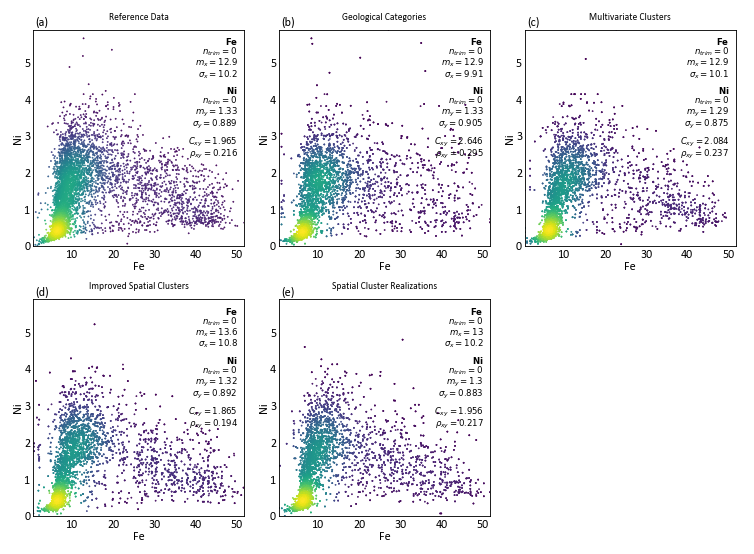

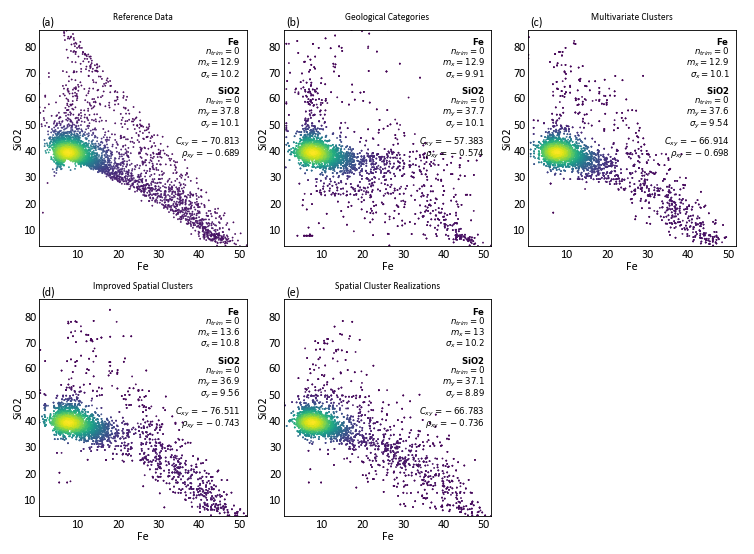

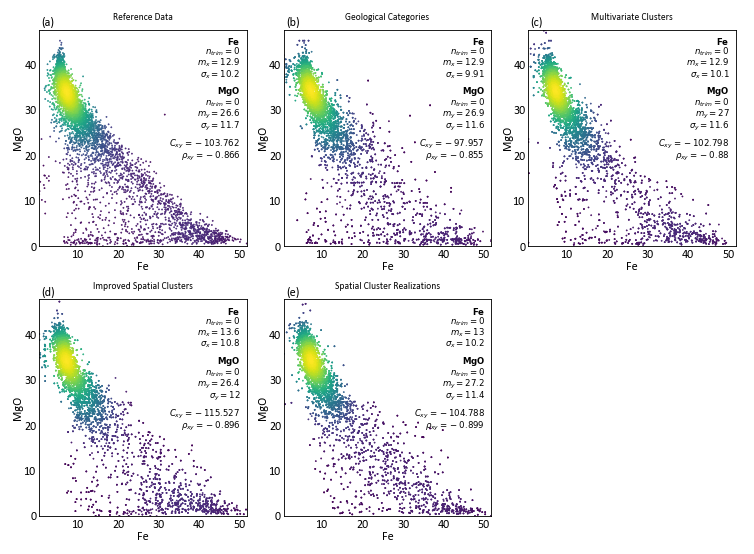

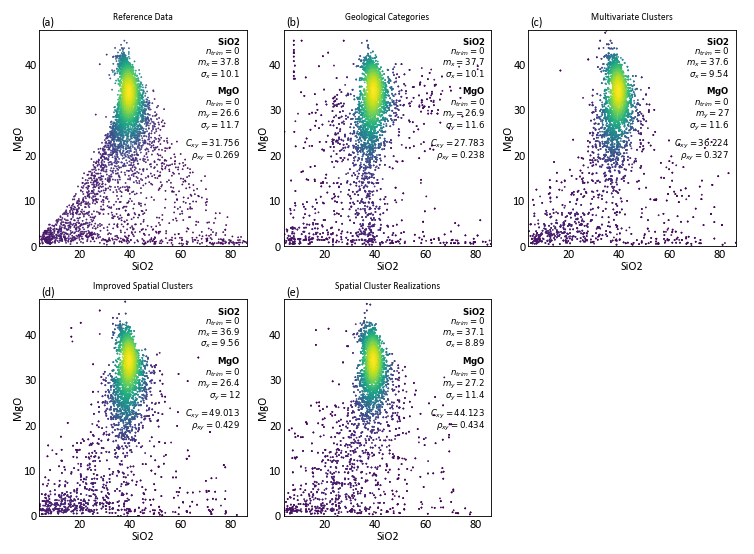

In [61]:
# collect the realization data
datasets = {'Reference': points[variables]}
ireal = np.random.randint(nreal)
for name, title in names.items():
    realization = pd.DataFrame()
    for var in variables:
        realvals = np.empty(0)
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            realvals = np.concatenate((realvals, thisdata[f'real{ireal}']))            
        realization[var] = realvals
    datasets[name] = realization

# plot reference, modelcats, clus, reals bivariate
for vari, varj in variter:
    axrow = qf.getax(nplot=5, shape=(2, 3), figsize=(3 * 2, 2 * 2.2))    
    # get a quick set of limits from the reference dataset
    dat = points[variables][vari]
    ylim = dat.min(), dat.max()
    dat = points[variables][varj]
    xlim = dat.min(), dat.max()
    for i, ((name, bivardat), ax) in enumerate(zip(datasets.items(), axrow)):
        gg.scatplt(bivardat[varj], bivardat[vari], ax=ax, cbar=False, 
                   title=bivartitles[name], s=0.5, c='kde', xlim=xlim, ylim=ylim, 
                   stat_xy=(0.97, 0.96), stat_ha='right', stat_va='top')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        qf(ax, fignum=i, grid=False)
    plt.tight_layout()
    exp.exportfigure(f'bivar_comparison_{vari}_{varj}.pdf')

# density differences

In [35]:
from collections import defaultdict
from multiprocessing import Pool

import seaborn as sns
from sklearn.neighbors.kde import KernelDensity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import tqdm

1. Loop over each fold
2. Calculate the density differences
3. Compute the average difference from each fold

In [36]:
kde_bandwidth = 0.7

In [37]:
basescores = {}
scalers = {}
truths = {}
for ifold in ifolds:
    truths[ifold] = thisdata = gg.PointContainer(f'{workdir}Validation{ifold:02}.dat')
    scalers[ifold] = StandardScaler().fit(thisdata[variables])
    transformed = scalers[ifold].transform(thisdata[variables])
    basekde = KernelDensity(bandwidth=kde_bandwidth, kernel='linear').fit(transformed)
    dens = np.exp(basekde.score_samples(transformed))
    basescores[ifold] = dens / dens.sum()

In [38]:
models = ['modelcats', 'mvclus', 'betteragglom', 'reals_ensbest']
labels = [names[m] for m in models]

In [39]:
# for each realization collect the data from th
parallel_args = []
for ireal in tqdm.tnrange(nreal):
    for name, ax in zip(models, acaxs):
        for ifold in ifolds:
            truth = truths[ifold][variables]
            simulated = pd.DataFrame()
            for var in variables:
                thisdata = valdict[var, name, ifold]
                simulated[var] = thisdata[f'real{ireal}']
            simulated_trans = scalers[ifold].transform(simulated)
            kde = KernelDensity(bandwidth=kde_bandwidth, kernel='linear').fit(simulated_trans)
            simulated_truth = scalers[ifold].transform(truth)
            parallel_args.append((kde, simulated_truth))

In [40]:
%%file parallel_kde.py
def parallel_kde(kde, samples_to_score):
    import numpy as np
    dens = np.exp(kde.score_samples(samples_to_score))
    return dens / dens.sum()

Overwriting parallel_kde.py


In [41]:
from parallel_kde import parallel_kde

In [42]:
res = gs.parallel_function(parallel_kde, parallel_args, nprocesses=12,
                           returnvals=True, reportprogress=True)

In [43]:
def kld(pk, qk):
    """ kld for two density estimates """
    smallnum = 1e-21
    idxs = (pk > smallnum) &  (qk > smallnum)
    return np.sum(pk[idxs] * np.log(pk[idxs] /  qk[idxs]))

In [44]:
iget = 0
diffs = defaultdict(lambda: defaultdict(list))
for ireal in range(nreal):
    for name in models:
        for ifold in ifolds:
            this_score = res[iget].get()
            diffs[name][ifold].append(
                kld(basescores[ifold],this_score)
            )
            iget += 1

In [45]:
xmax = -np.inf
xmin = np.inf
for name in diffs:
    for ifold, folddata in diffs[name].items():
        if np.min(folddata) < xmin:
            xmin = np.min(folddata)
        if np.max(folddata) > xmax:
            xmax = np.max(folddata)
xlim = (xmin, xmax)

In [46]:
palette = gs.catcmapfromcontinuous('Spectral', 4).colors

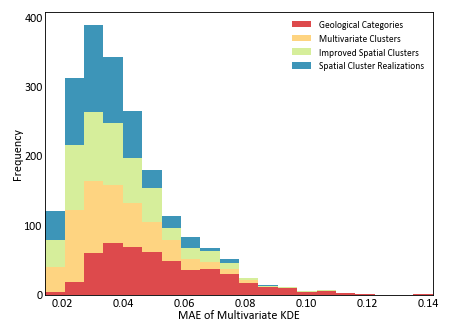

In [47]:
f, ax = plt.subplots(figsize=(4, 3))
plotdata = []
for name in diffs:
    datarr = np.empty(0)
    for ifold in ifolds:
        datarr = np.concatenate((datarr, diffs[name][ifold]))
    plotdata.append(datarr)
ax.hist(plotdata, label=labels, bins=20, histtype='barstacked', 
        color=palette)
qf(ax, xlim=xlim, fs=7, nticks=(10, 5), grid=False,
   xlabel='MAE of Multivariate KDE', ylabel='Frequency')
ax.legend(loc='upper right')
exp.exportfigure('density_error.pdf')

In [48]:
errordf = pd.DataFrame({names[n]: d for n, d in zip(diffs, plotdata)}).describe().T
errordf = errordf[['mean', 'std', '50%']]
errordf.columns = ['$\\mu$', '$\\sigma$', 'Median']
errordf

,$\mu$,$\sigma$,Median
Geological Categories,0.052359,0.020403,0.047839
Multivariate Clusters,0.036943,0.013524,0.034168
Improved Spatial Clusters,0.037442,0.014684,0.034917
Spatial Cluster Realizations,0.035104,0.012578,0.032692


In [49]:
import seaborn as sns

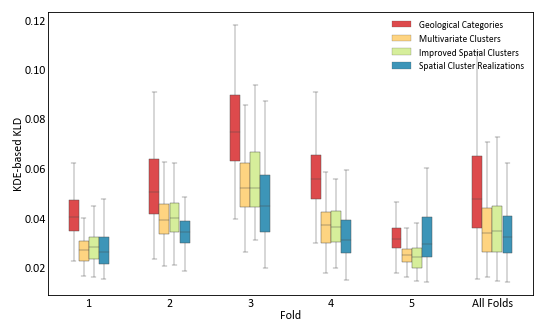

In [64]:
thisdata = pd.DataFrame()
meanvals = defaultdict(list)
for name in diffs:
    for ifold in ifolds:
        tempdata = pd.DataFrame()
        tempdata['Multivariate KDE Error'] = diffs[name][ifold]
        meanvals[names[name]].append(np.mean(diffs[name][ifold]))
        tempdata['Name'] = names[name]
        tempdata['Fold'] = ifold
        thisdata = pd.concat((thisdata, tempdata), axis=0, 
                             ignore_index=True, sort=False)
alldata = thisdata.copy()
alldata['Fold'] = 'All Folds'
thisdata = pd.concat((thisdata, alldata), axis=0, 
                      ignore_index=True, sort=False)

f, ax = plt.subplots(figsize=(5, 3))
ax = sns.boxplot(x='Fold', y='Multivariate KDE Error', hue='Name', data=thisdata, 
                 linewidth=0.25, width=0.5, ax=ax, palette=palette, showfliers=False,
                 saturation=1)
ax.legend(loc='upper right')
qf(ax, grid=False, ylabel='KDE-based KLD')
exp.exportfigure(f'density_error_byfold_boxplot.pdf')

In [56]:
errordf = pd.DataFrame(meanvals)
errordf.index = [f'Fold {i}' for i in ifolds]
errordf = pd.DataFrame(errordf.mean(axis=0)).T
errordf.index = ['Mean KDE Error']
errordf

,Geological Categories,Multivariate Clusters,Improved Spatial Clusters,Spatial Cluster Realizations
Mean KDE Error,0.052359,0.036943,0.037442,0.035104


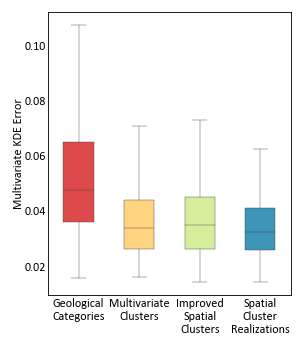

In [57]:
thisdata = pd.DataFrame()
for name in diffs:
    for ifold in ifolds:
        tempdata = pd.DataFrame()
        tempdata['Multivariate KDE Error'] = diffs[name][ifold]
        tempdata['Stationary Style'] = names[name].replace(' ', '\n')
        thisdata = pd.concat((thisdata, tempdata), axis=0, 
                             ignore_index=True, sort=False)

f, ax = plt.subplots(figsize=(2.5, 3))
ax = sns.boxplot(x='Stationary Style', y='Multivariate KDE Error', data=thisdata, 
                 palette=palette, linewidth=0.25, width=0.5, 
                 ax=ax, saturation=1, showfliers=False)
qf(ax, grid=False, xlabel='')
exp.exportfigure(f'density_error_boxplot.pdf')